<a href="https://colab.research.google.com/github/ducbao811/diveintocode-ml/blob/master/TensorFLow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Problem 1]

From what I have learnt so far in the course, below is what we need to do to implement deep learning:

* Weight and bias initialization
* Deciding what is the activation function for each layer and number of nodes in each layer
* Deciding batch size when perform forward/backward propagation
* Other parameters like epoch loop, learning rate,...



# [Problem 2]

In [ ]:
"""
Binary classification of Iris dataset using neural network implemented in TensorFlow
"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.test.gpu_device_name()
tf.disable_eager_execution() 
"""
tensorflowのバージョンを1.x系に変更した際は忘れずに
「!pip install tensorflow-gpu==1.14.0」でGPUのインストールをしておきましょう。
tf.test.gpu_device_name()でGPUの設定状態を確認し、認識されるかを確認します。
成功している場合はログが出力されます、認識されない場合は何も出力されません。
"""

#Load dataset
df = pd.read_csv("Iris.csv")
#Condition extraction from data frame
df = df[(df["Species"] == "Iris-versicolor") | (df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
# NumPy 配列に変換
X = np.array(X)
y = np.array(y)
# Convert label to number
y[y == "Iris-versicolor"] = 0
y[y == "Iris-virginica"] = 1
y = y.astype(np.int64)[:, np.newaxis]
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
class GetMiniBatch:
    """
    Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
# Hyperparameter settings
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
def example_net(x):
    """
    Simple 3-layer neural network
    """
    tf.random.set_random_seed(0)
    # Declaration of weight and bias
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.add and + are equivalent
    return layer_output


#Read network structure                              
logits = example_net(X)
# Objective function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Estimated result
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
#Initialization of variable
init = tf.global_variables_initializer()

#Run calculation graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 2.5685, val_loss : 19.7636, acc : 0.375
Epoch 1, loss : 0.4319, val_loss : 2.8135, acc : 0.750
Epoch 2, loss : 0.5106, val_loss : 0.7691, acc : 0.812
Epoch 3, loss : 0.0792, val_loss : 2.5278, acc : 0.500
Epoch 4, loss : 0.1210, val_loss : 0.6748, acc : 0.812
Epoch 5, loss : 0.0096, val_loss : 0.1199, acc : 0.938
Epoch 6, loss : 0.0215, val_loss : 0.0272, acc : 1.000
Epoch 7, loss : 0.0045, val_loss : 0.0282, acc : 1.000
Epoch 8, loss : 0.0059, val_loss : 0.0259, acc : 1.000
Epoch 9, loss : 0.0039, val_loss : 0.0121, acc : 1.000
Epoch 10, loss : 0.0024, val_loss : 0.0215, acc : 1.000
Epoch 11, loss : 0.0028, val_loss : 0.0118, acc : 1.000
Epoch 12, loss : 0.0022, val_loss : 0.0104, acc : 1.000
Epoch 13, loss : 0.0020, val_loss : 0.0114, acc : 1.000
Epoch 14, loss : 0.0018, val_loss : 0.0123, acc : 1.000
Epoch 15, loss : 0.0018, val_loss : 0.0107, acc : 1.000
Epoch 16, loss : 0.0017, val_loss : 0.0102, acc : 1.000
Epoch 17, loss : 0.0016, val_loss : 0.0105, acc : 1.000
E

*   Weight and bias are initialized with
```
tf.random_normal()
```
*   Adam Optimizer is used for gradient descent 



# [Problem 3]

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow.compat.v1 as tf
tf.test.gpu_device_name()
tf.disable_eager_execution()

In [19]:
# Loading dataset
df = pd.read_csv("Iris.csv")
y = df["Species"].values
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]].values

# Covert label y
y = OneHotEncoder().fit_transform(y[:,np.newaxis]).toarray()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [21]:
# Hyperparameter settings
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

In [23]:
#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [25]:
#Read network structure                              
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimated result
correct_pred = tf.equal(tf.arg_max(Y, 1), tf.arg_max(logits, 1))

#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#Initialization of variable
init = tf.global_variables_initializer()

In [26]:
#Run calculation graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 7.1547, val_loss : 60.1149, acc : 0.292
Epoch 1, loss : 5.0318, val_loss : 41.7341, acc : 0.375
Epoch 2, loss : 3.7180, val_loss : 34.6120, acc : 0.375
Epoch 3, loss : 3.1345, val_loss : 28.0894, acc : 0.375
Epoch 4, loss : 2.4825, val_loss : 22.4513, acc : 0.583
Epoch 5, loss : 1.9380, val_loss : 16.9703, acc : 0.583
Epoch 6, loss : 1.4045, val_loss : 11.6546, acc : 0.583
Epoch 7, loss : 0.9012, val_loss : 6.8562, acc : 0.625
Epoch 8, loss : 0.4005, val_loss : 2.1905, acc : 0.917
Epoch 9, loss : 0.0840, val_loss : 0.5242, acc : 0.917
Epoch 10, loss : 0.0353, val_loss : 0.3331, acc : 0.917
Epoch 11, loss : 0.0244, val_loss : 0.3380, acc : 0.917
Epoch 12, loss : 0.0199, val_loss : 0.3053, acc : 0.917
Epoch 13, loss : 0.0175, val_loss : 0.3677, acc : 0.917
Epoch 14, loss : 0.0157, val_loss : 0.3124, acc : 0.917
Epoch 15, loss : 0.0140, val_loss : 0.3236, acc : 0.917
Epoch 16, loss : 0.0123, val_loss : 0.3141, acc : 0.917
Epoch 17, loss : 0.0108, val_loss : 0.3142, acc : 0

# [Problem 4] Creating a model of House Prices

In [28]:
df = pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [45]:
X = df[["GrLivArea","YearBuilt"]].values
y = df[['SalePrice']].values

# Since the target variable distribution is positive skewed, we need to log-transform its
y = np.log1p(y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [53]:
# Hyperparameter settings
learning_rate = 0.001
batch_size = 10
num_epochs = 30
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

In [48]:
#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [49]:
logits = example_net(X)

# Objective function MSE
loss_op = tf.losses.mean_squared_error(labels=Y, predictions=logits)

# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#Initialization of variable
init = tf.global_variables_initializer()

Epoch 0, loss : 27049395.7998, val_loss : 11196228.0000
Epoch 1, loss : 434400.5127, val_loss : 1198504.8750
Epoch 2, loss : 55163.8015, val_loss : 225871.1094
Epoch 3, loss : 22207.8463, val_loss : 120487.1094
Epoch 4, loss : 13422.5239, val_loss : 78935.0859
Epoch 5, loss : 9215.1863, val_loss : 56751.0977
Epoch 6, loss : 6724.6721, val_loss : 43470.7422
Epoch 7, loss : 5130.3215, val_loss : 33162.2461
Epoch 8, loss : 4012.8192, val_loss : 25609.6387
Epoch 9, loss : 3258.5387, val_loss : 20402.6211
Epoch 10, loss : 2712.2869, val_loss : 16983.4844
Epoch 11, loss : 2317.8834, val_loss : 14474.1543
Epoch 12, loss : 2020.4940, val_loss : 12693.2656
Epoch 13, loss : 1783.9029, val_loss : 11301.4561
Epoch 14, loss : 1585.0084, val_loss : 10578.5830
Epoch 15, loss : 1427.0282, val_loss : 10403.4395
Epoch 16, loss : 1312.1517, val_loss : 10750.7734
Epoch 17, loss : 1218.9380, val_loss : 11414.8604
Epoch 18, loss : 1133.6396, val_loss : 11634.6787
Epoch 19, loss : 1049.2273, val_loss : 11180

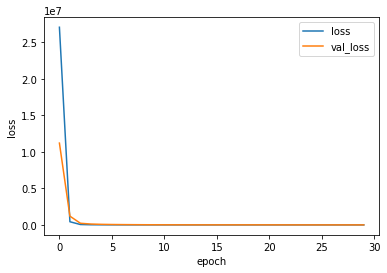

In [54]:
import matplotlib.pyplot as plt
#Run calculation graph
with tf.Session() as sess:
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        #Loop for each epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64)
        total_loss = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss = sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        total_loss /= n_samples
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        loss_list.append(total_loss)
        val_loss_list.append(val_loss)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, total_loss, val_loss))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()

# [Problem 5: Creating a MNIST model]

In [55]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(y_train[:, np.newaxis])
y_val = enc.transform(y_val[:, np.newaxis])
y_test = enc.transform(y_test[:, np.newaxis])

print(y_train.shape)
print(y_val.shape)

11501568/11490434 [==============================] - 0s 0us/step
(48000, 784)
(48000,)
(12000, 784)
(12000,)
(48000, 10)
(12000, 10)


In [56]:
# Hyperparameter settings
learning_rate = 0.01
batch_size = 100
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

In [58]:
#Determine the shape of the argument to be passed to the calculation graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# train mini batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [59]:
#Read network structure                              
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimated result
correct_pred = tf.equal(tf.arg_max(Y, 1), tf.arg_max(logits, 1))

#Indicator value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#Initialization of variable
init = tf.global_variables_initializer()

In [61]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 0.7702, val_loss : 0.5031, acc : 0.710, val_acc : 0.798
Epoch 1, loss : 0.2932, val_loss : 0.2298, acc : 0.750, val_acc : 0.785
Epoch 2, loss : 0.1819, val_loss : 0.1551, acc : 0.770, val_acc : 0.814
Epoch 3, loss : 0.1655, val_loss : 0.1256, acc : 0.750, val_acc : 0.836
Epoch 4, loss : 0.1356, val_loss : 0.1079, acc : 0.820, val_acc : 0.856
Epoch 5, loss : 0.0965, val_loss : 0.0994, acc : 0.850, val_acc : 0.869
Epoch 6, loss : 0.0699, val_loss : 0.0904, acc : 0.880, val_acc : 0.873
Epoch 7, loss : 0.0562, val_loss : 0.0849, acc : 0.900, val_acc : 0.885
Epoch 8, loss : 0.0492, val_loss : 0.0779, acc : 0.920, val_acc : 0.896
Epoch 9, loss : 0.0442, val_loss : 0.0765, acc : 0.930, val_acc : 0.909
Epoch 10, loss : 0.0458, val_loss : 0.0708, acc : 0.930, val_acc : 0.913
Epoch 11, loss : 0.0390, val_loss : 0.0703, acc : 0.940, val_acc : 0.911
Epoch 12, loss : 0.0420, val_loss : 0.0658, acc : 0.930, val_acc : 0.914
Epoch 13, loss : 0.0547, val_loss : 0.0642, acc : 0.940, val_